In [26]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import jax
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
from sklearn.mixture import GaussianMixture
key = jax.random.PRNGKey(42)
tf.random.set_seed(42)

In [2]:
readout_mode = 'softmax'
# readout_mode = 'sample'
encoding_mode = 'vanilla'
# encoding_mode = 'mean'
# encoding_mode = 'half'
n = 8
n_node = 8
K = tc.set_backend('jax')

In [3]:
import pandas as pd
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import itertools

In [4]:
df=pd.read_csv('files_cat.csv')
l=len(df['fname'])
for i in range(l):
    j="minor_proj_data/"+df['fname'][i]
    df.loc[i, 'fname'] = j

In [5]:
df.head()

,fname,class
0,minor_proj_data/1.png,1
1,minor_proj_data/2.png,1
2,minor_proj_data/3.png,1
3,minor_proj_data/4.png,1
4,minor_proj_data/5.png,1


In [6]:
img_col=[]
for i in df['fname']:
    img = Image.open(i)
    # Resize the image to 28x28 pixels
    img = img.resize((28, 28))
    # Convert the image to grayscale
    img = img.convert('L')
    # Convert the image data to a NumPy array and normalize to range [0, 1]
    img = np.array(img,dtype='uint8')
    img_col.append(img)

In [7]:
df['img']=img_col
df=df.drop('fname',axis=1)
X=df.loc[:,df.columns!='class'].values
Y=df.loc[:,df.columns=='class'].values

In [37]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [38]:
xtrain=[]
for i in x_train:
    for j in i:
        xtrain.append(j)
x_train=np.array(xtrain)

In [39]:
ytrain=[]
for i in y_train:
    for j in i:
        ytrain.append(j)
y_train=np.array(ytrain)

In [40]:
xtest=[]
for i in x_test:
    for j in i:
        xtest.append(j)
x_test=np.array(xtest)

In [41]:
ytest=[]
for i in y_test:
    for j in i:
        ytest.append(j)
y_test=np.array(ytest)

In [42]:
x_train = x_train / 255.0
if encoding_mode == 'vanilla':
    mean = 0
elif encoding_mode == 'mean':
    mean = jnp.mean(x_train, axis=0)
elif encoding_mode == 'half':
    mean = 0.5

x_train = x_train - mean
x_train = tf.image.resize(x_train[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_train = x_train / jnp.sqrt(jnp.sum(x_train**2, axis=-1, keepdims=True))

x_test = x_test / 255.0
x_test = x_test - mean
x_test = tf.image.resize(x_test[..., tf.newaxis], (int(2**(n/2)), int(2**(n/2)))).numpy()[..., 0].reshape(-1, 2**n)
x_test = x_test / jnp.sqrt(jnp.sum(x_test**2, axis=-1, keepdims=True))

#y_train = jax.nn.one_hot(y_train, n_node)
y_test = jax.nn.one_hot(y_test, n_node)

def filter_pair(x, y, a, b):
    keep = (y == a) | (y == b)
    x, y = x[keep], y[keep]
    y = jax.nn.one_hot(y, n_node)
    return x, y

In [43]:
def clf(params, c, k):
    for j in range(k):
        for i in range(n - 1):
            c.cnot(i, i + 1)
        for i in range(n):
            c.rx(i, theta=params[3 * j, i])
            c.rz(i, theta=params[3 * j + 1, i])
            c.rx(i, theta=params[3 * j + 2, i])
    return c

def readout(c):
    if readout_mode == 'softmax':
        logits = []
        for i in range(n_node):
            logits.append(jnp.real(c.expectation([tc.gates.z(), [i,]])))
        logits = jnp.stack(logits, axis=-1) * 10
        probs = jax.nn.softmax(logits)
    elif readout_mode == 'sample':
        wf = jnp.abs(c.wavefunction()[:n_node])**2
        probs = wf / jnp.sum(wf)
    return probs

In [44]:
def loss(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return -jnp.mean(jnp.sum(y * jnp.log(probs + 1e-7), axis=-1))
loss = K.jit(loss, static_argnums=[3])

In [45]:
def accuracy(params, x, y, k):
    c = tc.Circuit(n, inputs=x)
    c = clf(params, c, k)
    probs = readout(c)
    return jnp.argmax(probs, axis=-1) == jnp.argmax(y, axis=-1)
accuracy = K.jit(accuracy, static_argnums=[3])

In [46]:
k = 6
compute_loss = K.jit(K.vectorized_value_and_grad(loss, vectorized_argnums=[1, 2]), static_argnums=[3])
compute_accuracy = K.jit(K.vmap(accuracy, vectorized_argnums=[1, 2]), static_argnums=[3])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/5: loss=2.5762, acc=0.0156
epoch 1, 0/5: loss=1.2220, acc=0.9062
epoch 2, 0/5: loss=0.5095, acc=1.0000
epoch 3, 0/5: loss=0.2555, acc=1.0000
epoch 4, 0/5: loss=0.1574, acc=1.0000


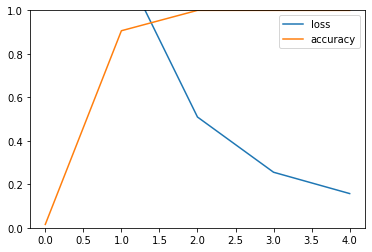

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/10: loss=1.8338, acc=0.5391
epoch 1, 0/10: loss=0.1479, acc=1.0000
epoch 2, 0/10: loss=0.0447, acc=1.0000
epoch 3, 0/10: loss=0.0250, acc=1.0000
epoch 4, 0/10: loss=0.0170, acc=1.0000


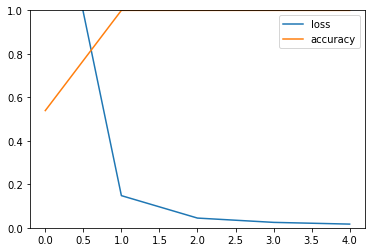

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 0, 0/6: loss=1.2607, acc=0.9844
epoch 1, 0/6: loss=0.2728, acc=1.0000
epoch 2, 0/6: loss=0.0927, acc=1.0000
epoch 3, 0/6: loss=0.0450, acc=1.0000
epoch 4, 0/6: loss=0.0279, acc=1.0000


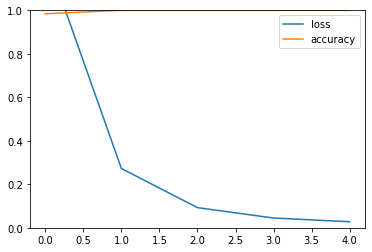

In [47]:
params_list = []
gmm_list = []
all_train_loss = []
all_train_acc = []
for node in tqdm(range(3)):
    x_train_node, y_train_node = filter_pair(x_train, y_train, 0, node + 1)
    data = tf.data.Dataset.from_tensor_slices((x_train_node, y_train_node)).batch(128)

    # GMM
    gmm = GaussianMixture(n_components=5, max_iter=100, random_state=42)
    gmm.fit(x_train_node)
    gmm_list.append(gmm)

    key, subkey = jax.random.split(key)
    params = jax.random.normal(subkey, (3 * k, n))
    opt = optax.adam(learning_rate=1e-2)
    opt_state = opt.init(params)

    loss_list = []
    acc_list = []
    for e in tqdm(range(5), leave=False):
        for i, (x, y) in enumerate(data):
            x = x.numpy()
            y = y.numpy()
            loss_val, grad_val = compute_loss(params, x, y, k)
            updates, opt_state = opt.update(grad_val, opt_state, params)
            params = optax.apply_updates(params, updates)
            loss_mean = jnp.mean(loss_val)
            if i % 20 == 0:
                acc = jnp.mean(compute_accuracy(params, x, y, k))
                acc_list.append(acc)
                loss_list.append(loss_mean)
                print(f'epoch {e}, {i}/{len(data)}: loss={loss_mean:.4f}, acc={acc:.4f}')
    all_train_loss.append(loss_list)
    all_train_acc.append(acc_list)
    

    plt.plot(loss_list)
    plt.plot(acc_list)
    plt.legend(['loss', 'accuracy'])
    plt.ylim(0, 1)
    plt.show()

    params_list.append(params)